In [91]:
import pandas as pd
import pendulum
import seaborn as sn
import matplotlib.pyplot as plt

In [5]:
from urllib import request
import gzip
import shutil

In [13]:
def download_data(url, filename):
    # Given a url for a compressed tsv file
    # unzip and save tsv file locally to 
    # location indicated by filename
    with request.urlopen(url) as response:
        with gzip.GzipFile(fileobj=response) as uncompressed, open(filename, 'wb') as out_file:
            shutil.copyfileobj(uncompressed, out_file)

In [24]:
file_dicts = {
    'ratings': {
        'url': 'https://datasets.imdbws.com/title.ratings.tsv.gz',
        'filename': '../data/ratings.tsv'
    },
    'names': {
        'url': 'https://datasets.imdbws.com/name.basics.tsv.gz',
        'filename': '../data/names.tsv'
    },
    'title_akas': {
        'url': 'https://datasets.imdbws.com/title.akas.tsv.gz',
        'filename': '../data/title_akas.tsv'
    },
    'title_basics': {
        'url': 'https://datasets.imdbws.com/title.basics.tsv.gz',
        'filename': '../data/title_basics.tsv'
    },
    'crew': {
        'url': 'https://datasets.imdbws.com/title.crew.tsv.gz',
        'filename': '../data/crew.tsv'
    },
    'episode': {
        'url': 'https://datasets.imdbws.com/title.episode.tsv.gz',
        'filename': '../data/episode.tsv'
    },
    'principals': {
        'url': 'https://datasets.imdbws.com/title.principals.tsv.gz',
        'filename': '../data/principals.tsv'
    }
}


In [25]:
for key in file_dicts.keys():
    url = file_dicts[key]['url']
    filename = file_dicts[key]['filename']
    download_data(url, filename)

In [26]:
ratings = pd.read_csv(file_dicts['ratings']['filename'], delimiter='\t')

In [27]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1849
1,tt0000002,6.0,241
2,tt0000003,6.5,1616
3,tt0000004,6.0,156
4,tt0000005,6.2,2442


In [43]:
# checking to see the distribution of number of Votes
# most titles have very few votes
# and most title have a score between 6-8
ratings.describe()

,averageRating,numVotes
count,1.206957e+06,1.206957e+06
mean,6.923594e+00,9.965694e+02
std,1.397226e+00,1.662288e+04
min,1.000000e+00,5.000000e+00
25%,6.200000e+00,1.100000e+01
50%,7.100000e+00,2.400000e+01
75%,7.900000e+00,9.400000e+01
max,1.000000e+01,2.529262e+06


In [28]:
title_basics = pd.read_csv(file_dicts['title_basics']['filename'], delimiter='\t')

/Users/elaine/Library/Caches/pypoetry/virtualenvs/imdb-ratings-ej0iMkbW-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Doing some filtering for the titles we will be considering for model building

1. only considering movies (`titleType == 'movie'`)
2. only consider movies that have ratings
3. only consider movies that have more than 100 votes. Movies with fewer ratings are excluded for data quality purposes since outlier scores can heavily influence the final average rating.

In [33]:
title_basics = title_basics[title_basics.titleType=='movie']

In [188]:
title_ratings = title_basics.merge(ratings, on='tconst')

In [189]:
title_ratings = title_ratings[title_ratings.numVotes>100]

In [190]:
len(title_ratings)

109919

In [191]:
# startYear is mixed type because some movies have unknown startYear.
# After filtering based on having ratings and more than 100 votes, we only have two 
# titles that have unknown startYear. 
# Remove these since occurances are so rare.

title_ratings.loc[title_ratings['startYear']=='\\N']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
147557,tt1027755,movie,Tied in Blood,Tied in Blood,0,\N,\N,88,"Drama,Horror,Mystery",3.5,223
158348,tt11777460,movie,Sri Bharatha Baahubali,Sri Bharatha Baahubali,0,\N,\N,164,Comedy,7.6,2563


In [192]:
title_ratings = title_ratings[title_ratings['startYear']!='\\N']
title_ratings['startYear'] = title_ratings.startYear.astype(int)

#### Feature exploration and engineering

##### title basics
- make startYear a categorical feature.
- make years since opening a numerical feature.
- split out individual genres, and change into one-hot encoding for genre

In [183]:
# The year the movie premiered should be considered a categorical
# feature instead of quantitative since the year doesn't simply represent
# the age of the movie, but also different movie-making technology and style.
# Therefore I want to change the startYear feature into a categorical feature.

# 75% of rated movies are made after 1980
title_ratings.startYear.describe()

count    109917.000000
mean       1995.533985
std          24.098151
min        1904.000000
25%        1982.000000
50%        2005.000000
75%        2014.000000
max        2022.000000
Name: startYear, dtype: float64

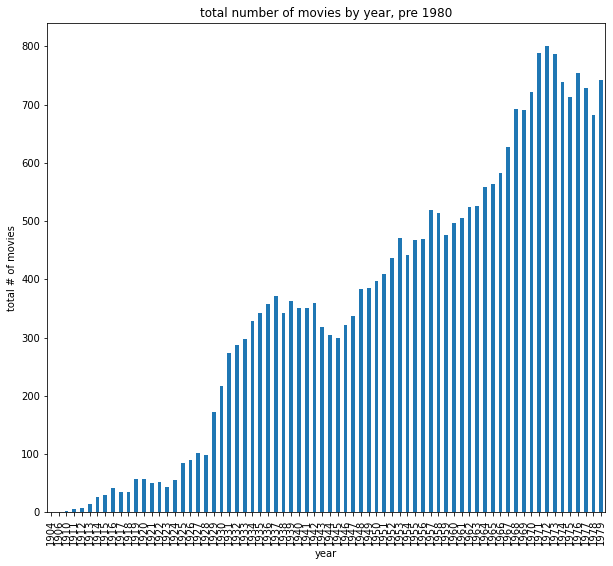

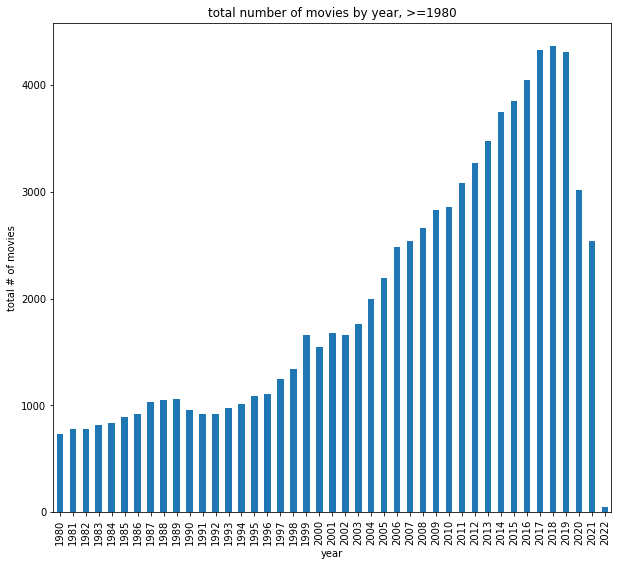

In [141]:
# Taking a closer look at total number of titles by startYear for pre 1980 movies
# There are very few rated movies before 1930
fig = plt.figure(figsize=(10,9))
title_ratings[
    title_ratings.startYear<1980
].sort_values(by='startYear')['startYear'].value_counts(sort=False).plot(kind='bar')
plt.title('total number of movies by year, pre 1980')
plt.ylabel('total # of movies')
plt.xlabel('year')
plt.show()
# Taking a closer look at total number of movies by year after 1980
fig = plt.figure(figsize=(10,9))
title_ratings[
    title_ratings.startYear>=1980
].sort_values(by='startYear')['startYear'].value_counts(sort=False).plot(kind='bar')
plt.title('total number of movies by year, >=1980')
plt.ylabel('total # of movies')
plt.xlabel('year');

In [193]:
bin_edges = [0, 1930, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2025]
labels = ['pre-1930', '1930-1950', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010-now' ]

In [194]:
title_ratings['decade'] = pd.cut(title_ratings.startYear, bins = bin_edges, labels=labels)

In [195]:
title_ratings = title_ratings.reset_index(drop=True)

In [196]:
basic_features = title_ratings[['tconst']].join(pd.get_dummies(title_ratings.decade))

In [197]:
basic_features

,tconst,pre-1930,1930-1950,1950s,1960s,1970s,1980s,1990s,2000s,2010-now
0,tt0000574,1,0,0,0,0,0,0,0,0
1,tt0001258,1,0,0,0,0,0,0,0,0
2,tt0001892,1,0,0,0,0,0,0,0,0
3,tt0002101,1,0,0,0,0,0,0,0,0
4,tt0002130,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
109912,tt9914286,0,0,0,0,0,0,0,0,1
109913,tt9914942,0,0,0,0,0,0,0,0,1
109914,tt9916190,0,0,0,0,0,0,0,0,1
109915,tt9916270,0,0,0,0,0,0,0,0,1


In [198]:
title_ratings.genres = title_ratings.genres.str.split(',')

In [199]:
basic_features = basic_features.join(
    pd.get_dummies(
        pd.DataFrame(title_ratings.genres.tolist()).stack()
    ).astype(int).sum(level=0)
)

/Users/elaine/Library/Caches/pypoetry/virtualenvs/imdb-ratings-ej0iMkbW-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  after removing the cwd from sys.path.


In [203]:
basic_features[['tconst', 'Action', 'Adventure', 'Biography', 'Drama']].head()

,tconst,Action,Adventure,Biography,Drama
0,tt0000574,1,1,1,0
1,tt0001258,0,0,0,1
2,tt0001892,0,0,0,1
3,tt0002101,0,0,0,1
4,tt0002130,0,1,0,1


In [205]:
# adding in runtime as another feature
basic_features['runtime'] = title_ratings['runtimeMinutes']

In [495]:
basic_features['years_since_opening'] = 2022 - title_ratings['startYear']

In [496]:
basic_features.head()

,tconst,pre-1930,1930-1950,1950s,1960s,1970s,1980s,1990s,2000s,2010-now,...,Sport,Talk-Show,Thriller,War,Western,\N,runtime,n_regions,n_languages,years_since_opening
0,tt0000574,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,70,7.0,1.0,116
1,tt0001258,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,45,7.0,2.0,112
2,tt0001892,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,53,10.0,2.0,111
3,tt0002101,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,100,5.0,1.0,110
4,tt0002130,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,71,12.0,2.0,111


##### title akas

- contains information about alternative titles to each movie, and the regions the movies were distributed
- to condense this information, for each unique titleID (unique to the movie), we count the number of unique regions and languages

In [221]:
title_akas = pd.read_csv(file_dicts['title_akas']['filename'], delimiter='\t')

/Users/elaine/Library/Caches/pypoetry/virtualenvs/imdb-ratings-ej0iMkbW-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [222]:
title_akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [81]:
akas_summary = title_akas.groupby('titleId')[['region', 'language']].nunique()

In [213]:
akas_summary.reset_index(inplace=True)

In [215]:
akas_summary.columns = ['tconst', 'n_regions', 'n_languages']

In [216]:
akas_summary.head()

,tconst,n_regions,n_languages
0,tt0000001,8,2
1,tt0000002,8,2
2,tt0000003,9,2
3,tt0000004,7,2
4,tt0000005,8,2


In [218]:
# adding akas summary features into basic features
basic_features = basic_features.merge(akas_summary, on='tconst', how='left')

In [219]:
basic_features.head()

,tconst,pre-1930,1930-1950,1950s,1960s,1970s,1980s,1990s,2000s,2010-now,...,Short,Sport,Talk-Show,Thriller,War,Western,\N,runtime,n_regions,n_languages
0,tt0000574,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,70,7.0,1.0
1,tt0001258,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,45,7.0,2.0
2,tt0001892,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,53,10.0,2.0
3,tt0002101,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100,5.0,1.0
4,tt0002130,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,71,12.0,2.0


##### personnel related features
- First split principal participants of the movie into crew vs actors
    - For actors: Take top 2 billing actors/actresses
    - For crew: take director, writer, cinematographer

- For each principal participant selected, find the total number of other films that have been rated, as well as the average ratings of all other films they have top-billings in.

- summary personnel-based scores for each movie includes:
    - average top billing actors' rating (take average of personal averages)
    - average # of vote for top billing actors' other movies
    - top director average rating
    - top director average # votes of other movies
    - average cinematographer rating

In [87]:
names = pd.read_csv(file_dicts['names']['filename'], delimiter='\t')

In [88]:
names.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0031983,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0049189,tt0057345,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0072562,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0050986,tt0060827,tt0083922"


In [229]:
principals = pd.read_csv(file_dicts['principals']['filename'], delimiter='\t')

In [278]:
principals = principals.merge(title_ratings[['tconst', 'averageRating', 'numVotes']],
                             on='tconst')

In [279]:
p_actors = principals[principals.category.isin(['actor', 'actress'])]

In [319]:
p_actors['rank'] = p_actors.groupby('tconst')['ordering'].rank()

/Users/elaine/Library/Caches/pypoetry/virtualenvs/imdb-ratings-ej0iMkbW-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [320]:
p2_actors = p_actors.sort_values('rank').groupby('tconst').head(2)

In [350]:
p5_actors = p_actors.sort_values('rank').groupby('tconst').head(5)

In [351]:
p2_actors_other_movies = p2_actors.merge(
    p5_actors[['tconst', 'nconst', 'averageRating', 'numVotes']], 
    on='nconst', how='left', suffixes= ('', '_y'))

In [352]:
p2_actors_other_movies = p2_actors_other_movies[
    p2_actors_other_movies['tconst']!=p2_actors_other_movies['tconst_y']]

In [353]:
p2_actors_summary = pd.DataFrame(
    p2_actors_other_movies.groupby(['tconst', 'nconst', 'rank'])['averageRating_y'].mean())

In [354]:
p2_actor_summary

averageRating_y   numVotes_y
tconst    nconst    ordering                              
tt0001892 nm0003425 1                6.766667   709.666667
tt0002423 nm0417837 2                6.986667  3569.000000
          nm0624470 1                6.470000   397.600000
tt0002445 nm0637019 1                6.300000   113.000000
          nm0784988 2                6.400000   441.000000
...                                       ...          ...
tt9916190 nm2018573 2                5.400000   142.000000
tt9916270 nm0144812 1                6.350000  1175.428571
          nm3080119 2                5.360000   644.600000
tt9916362 nm0107165 2                6.185714  1397.571429
          nm3766704 1                6.600000   132.000000

[149320 rows x 2 columns]

In [355]:
p2_actors_summary = p2_actors_summary.join(
    pd.DataFrame(p2_actors_other_movies.groupby(['tconst', 'nconst', 'rank'])['numVotes_y'].mean()),
)

In [356]:
p2_actors_features = p2_actors_summary.reset_index().pivot(index='tconst', columns='rank', values=['averageRating_y', 'numVotes_y'])

In [357]:
p2_actors_features.columns = ['actor1_rating', 'actor2_rating', 'actor1_nvotes', 'actor2_nvotes']

In [358]:
p2_actors_features

,actor1_rating,actor2_rating,actor1_nvotes,actor2_nvotes
tconst,,,,
tt0001892,6.425000,NaN,563.5000,NaN
tt0002186,7.500000,NaN,395.0000,NaN
tt0002423,6.508333,6.887500,592.2500,3386.062500
tt0002445,6.300000,6.400000,113.0000,441.000000
tt0002646,6.550000,NaN,343.0000,NaN
...,...,...,...,...
tt9914192,6.000000,5.000000,855.0000,480.500000
tt9914942,6.700000,NaN,199.0000,NaN
tt9916190,NaN,5.100000,NaN,391.200000


##### top billing director features
- average rating for other movies by the director
- average # of votes for other movies by the director

In [363]:
p_directors = principals[principals['category']=='director'].sort_values('ordering').groupby('tconst').head(1)

In [365]:
p_directors_other_movies = p_directors.merge(
    p_directors[['tconst', 'nconst', 'averageRating', 'numVotes']], 
    on='nconst', how='left', suffixes= ('', '_y'))

In [366]:
p_directors_other_movies = p_directors_other_movies[
    p_directors_other_movies['tconst']!=p_directors_other_movies['tconst_y']]

In [373]:
p_directors_features = p_directors_other_movies.groupby(['tconst'])[['averageRating_y', 'numVotes_y']].mean()

In [396]:
p_directors_features.columns = ['dir_averageRating', 'dir_numVotes']
p_directors_features.head()

,dir_averageRating,dir_numVotes
tconst,,
tt0001258,6.166667,289.666667
tt0002199,6.100000,739.000000
tt0002423,6.988571,4541.714286
tt0002646,5.866667,201.333333
tt0002898,7.600000,117.000000


##### getting the same features for top billed cinematographer

In [381]:
p_cin = principals[principals['category']=='cinematographer'].sort_values('ordering').groupby('tconst').head(1)

In [383]:
p_cin_other_movies = p_cin.merge(
    p_cin[['tconst', 'nconst', 'averageRating', 'numVotes']], 
    on='nconst', how='left', suffixes= ('', '_y'))

In [384]:
p_cin_other_movies = p_cin_other_movies[
    p_cin_other_movies['tconst']!=p_cin_other_movies['tconst_y']]

In [385]:
p_cin_features = p_cin_other_movies.groupby(['tconst'])[['averageRating_y', 'numVotes_y']].mean()

In [397]:
p_cin_features.columns = ['cin_averageRating', 'cin_numVotes']
p_cin_features.head()

,cin_averageRating,cin_numVotes
tconst,,
tt0001258,5.850000,157.000000
tt0002423,6.673077,992.730769
tt0002898,5.850000,150.500000
tt0003014,6.633333,290.888889
tt0003037,7.000000,2049.750000


### Modeling
Since a lot of the movie title-related features are categorical, I chose to use a tree-based model. There are also a lot of missing values for the personel-based features (for example, when a top-billing actor doesn't have other top-billing movies, or a first time director). Since we have a time constrain, I choose to use xgboost since it can handle missing values fairly well. Given more time, I would like to create better ways to deal with missing values.

In [387]:
base_data = title_ratings[['tconst', 'averageRating']]

In [497]:
# add in actor-based features
features = basic_features.merge(p2_actors_features.reset_index(),
                                on='tconst',
                                how='left' )

In [498]:
# add in director-based features
features = features.merge(p_directors_features.reset_index(),
                          on='tconst',
                          how='left'
                         )
features.head()

,tconst,pre-1930,1930-1950,1950s,1960s,1970s,1980s,1990s,2000s,2010-now,...,runtime,n_regions,n_languages,years_since_opening,actor1_rating,actor2_rating,actor1_nvotes,actor2_nvotes,dir_averageRating,dir_numVotes
0,tt0000574,1,0,0,0,0,0,0,0,0,...,70,7.0,1.0,116,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0001258,1,0,0,0,0,0,0,0,0,...,45,7.0,2.0,112,NaN,NaN,NaN,NaN,6.166667,289.666667
2,tt0001892,1,0,0,0,0,0,0,0,0,...,53,10.0,2.0,111,6.425,NaN,563.5,NaN,NaN,NaN
3,tt0002101,1,0,0,0,0,0,0,0,0,...,100,5.0,1.0,110,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0002130,1,0,0,0,0,0,0,0,0,...,71,12.0,2.0,111,NaN,NaN,NaN,NaN,NaN,NaN


In [499]:
# add in cinematographer-based features
features = features.merge(p_cin_features.reset_index(),
                          on='tconst',
                          how='left'
                         )
features.head()

,tconst,pre-1930,1930-1950,1950s,1960s,1970s,1980s,1990s,2000s,2010-now,...,n_languages,years_since_opening,actor1_rating,actor2_rating,actor1_nvotes,actor2_nvotes,dir_averageRating,dir_numVotes,cin_averageRating,cin_numVotes
0,tt0000574,1,0,0,0,0,0,0,0,0,...,1.0,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0001258,1,0,0,0,0,0,0,0,0,...,2.0,112,NaN,NaN,NaN,NaN,6.166667,289.666667,5.85,157.0
2,tt0001892,1,0,0,0,0,0,0,0,0,...,2.0,111,6.425,NaN,563.5,NaN,NaN,NaN,NaN,NaN
3,tt0002101,1,0,0,0,0,0,0,0,0,...,1.0,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0002130,1,0,0,0,0,0,0,0,0,...,2.0,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [473]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

In [500]:
X = features.drop('tconst', axis='columns')
y = base_data.drop('tconst', axis='columns')

In [501]:
#check features to make sure data types are correct
X.dtypes

pre-1930                 uint8
1930-1950                uint8
1950s                    uint8
1960s                    uint8
1970s                    uint8
1980s                    uint8
1990s                    uint8
2000s                    uint8
2010-now                 uint8
Action                   int64
Adult                    int64
Adventure                int64
Animation                int64
Biography                int64
Comedy                   int64
Crime                    int64
Documentary              int64
Drama                    int64
Family                   int64
Fantasy                  int64
Film-Noir                int64
History                  int64
Horror                   int64
Music                    int64
Musical                  int64
Mystery                  int64
News                     int64
Reality-TV               int64
Romance                  int64
Sci-Fi                   int64
Short                    int64
Sport                    int64
Talk-Sho

In [502]:
#correct runtime data type
X.loc[X.runtime=='\\N', 'runtime'] = None
X['runtime'] = X['runtime'].astype('float')

In [503]:
X.runtime.dtypes

dtype('float64')

In [504]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

In [505]:
model = XGBRegressor()

In [509]:
parameters = {
    'max_depth': [3, 6, 10, 15],
    'n_estimators': [80, 100, 150],
    'learning_rate': [0.01, 0.1, 0.3], 
    'colsample_bylevel': [0.5, 1]
}


In [510]:
clf = GridSearchCV(estimator=model, 
                   param_grid=parameters,
                   scoring='r2', 
                   verbose=1)


In [ ]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [485]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [486]:
clf.best_estimator_.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [487]:
y_pred = clf.best_estimator_.predict(X_test)

In [457]:
y_train_pred = model.predict(X_train)

In [488]:
r2_score(y_test, y_pred)

0.5306019821575815

/Users/elaine/Library/Caches/pypoetry/virtualenvs/imdb-ratings-ej0iMkbW-py3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

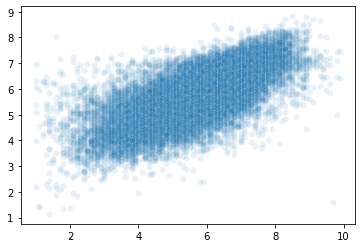

In [489]:
sn.scatterplot(y_test.transpose().values[0], y_pred, alpha=0.1)

In [492]:
feature_importances = pd.DataFrame(zip(X.columns, clf.best_estimator_.feature_importances_),
                                   columns=['feature', 'importance']
                                  )

In [493]:
feature_importances.sort_values('importance', ascending=False)

,feature,importance
16,Documentary,0.297332
22,Horror,0.142029
44,dir_averageRating,0.103597
40,actor1_rating,0.037079
17,Drama,0.033343
27,Reality-TV,0.029733
29,Sci-Fi,0.027397
12,Animation,0.019895
41,actor2_rating,0.019671
10,Adult,0.015443


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1080x936 with 0 Axes>

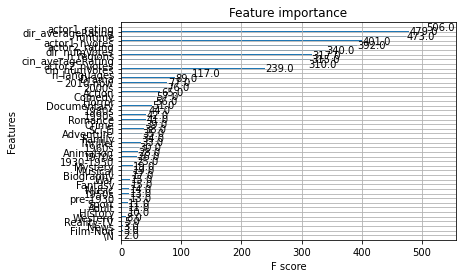

In [467]:
fig = plt.figure(figsize=(15,13))
xgboost.plot_importance(model)